In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Use Cuda

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

Prioritized Replay Buffer
Prioritized Experience Replay: https://arxiv.org/abs/1511.05952

In [4]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        #assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

In [5]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

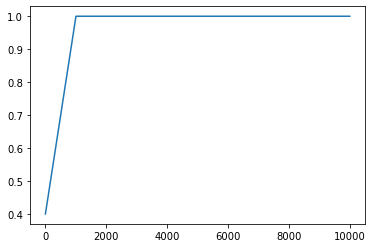

In [6]:
plt.plot([beta_by_frame(i) for i in range(10000)])

Cart Pole Environment

In [7]:
env_id = "CartPole-v0"
env = gym.make(env_id)

/Users/drewl/opt/anaconda3/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [8]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)


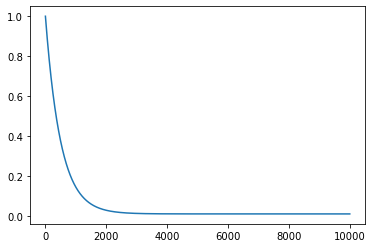

In [9]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

Deep Q Network

In [10]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [11]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = NaivePrioritizedBuffer(100000)

Synchronize Current Policy and Target Net

In [12]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [13]:
update_target(current_model, target_model)

Computing Temporal Difference Loss

In [14]:
def compute_td_loss(batch_size, beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    weights    = Variable(torch.FloatTensor(weights))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss  = (q_value - expected_q_value.detach()).pow(2) * weights
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()
    
    return loss

In [15]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

Training

In [16]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

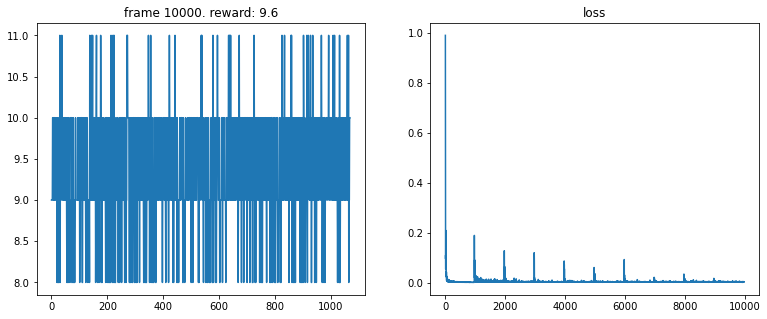

In [17]:
state = env.reset()
reward_arr = []
epsilon = epsilon_by_frame(1)
    
action = current_model.act(state, epsilon)  # User-defined policy function
    
if action is not int():
    action = 0
    
next_state, reward, terminated, truncated, _ = env.step(action)
done = terminated or truncated
replay_buffer.push(state[0], action, reward, next_state, done)
episode_reward += reward
reward_arr.append(episode_reward)
    
if terminated or truncated:
    observation, info = env.reset()
    
for frame_idx in range(2, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    
    action = current_model.act(next_state, epsilon)  # User-defined policy function
    
    if action is not int():
        action = 0
        
    state = next_state
    next_state, reward, terminated, truncated, _ = env.step(action)
    
    done = terminated or truncated
    replay_buffer.push(state, action, reward, next_state, done)
    
    episode_reward += reward
    reward_arr.append(episode_reward)
    
    if terminated or truncated:
        next_state, info = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
   
    """
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
    
    """
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        print("batch_size: ",batch_size)
        print("beta: ",beta)
        loss = compute_td_loss(batch_size, beta)
        losses.append(loss.item()) #ussed to be loss.data
    
    
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
        
    
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)
    


In [18]:
#from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [19]:
"""
env_id = "Pong-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)
"""


'\nenv_id = "Pong-v4"\nenv    = make_atari(env_id)\nenv    = wrap_deepmind(env)\nenv    = wrap_pytorch(env)\n'